In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
# Core imports
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr
import os
import pickle

# Captum for Grad-CAM
from captum.attr import LayerGradCam, LayerAttribution

# ROAD imports
import road
from road import run_road, set_device, ImputedDataset, ThresholdDataset
from road.imputations import NoisyLinearImputer, ImpaintingImputation, ImpaintingImputationNS

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu126
CUDA available: True


## 1. Configuration

In [122]:
# ============== Configuration ==============
IMAGENET_PATH = '/mnt/abka03/xlvlm_data/imagenet_1000'
NUM_SAMPLES = 10  # Number of test samples to use
SEED = 42
BATCH_SIZE = 8

# Percentages for ROAD benchmark
PERCENTAGES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# ImageNet normalization parameters
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
IMAGE_SIZE = 224

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_device(str(DEVICE))
print(f"Using device: {DEVICE}")
print(f"ROAD device: {road.use_device}")

Using device: cuda
ROAD device: cuda


## 2. Load ImageNet Dataset

In [123]:
# Transform for tensor only (no normalization - needed for imputation)
transform_tensor = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
])

# Transform with normalization (for model inference)
transform_normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)

# Full transform for explanation generation
transform_full = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Load validation set with tensor-only transform
imagenet_val = datasets.ImageFolder(
    os.path.join(IMAGENET_PATH, 'val'),
    transform=transform_tensor
)

print(f"Full validation set size: {len(imagenet_val)}")
print(f"Number of classes: {len(imagenet_val.classes)}")

Full validation set size: 50000
Number of classes: 1000


In [84]:
# Create random subset of NUM_SAMPLES images
np.random.seed(SEED)
torch.manual_seed(SEED)

all_indices = list(range(len(imagenet_val)))
np.random.shuffle(all_indices)
subset_indices = all_indices[:NUM_SAMPLES]

# Create subset dataset
imagenet_subset = torch.utils.data.Subset(imagenet_val, subset_indices)
print(f"Subset size: {len(imagenet_subset)}")

# Preview sample labels
print("\nSelected samples:")
for i, idx in enumerate(subset_indices):
    _, label = imagenet_val[idx]
    class_name = imagenet_val.classes[label]
    print(f"  {i}: Index={idx}, Class={label} ({class_name})")

Subset size: 10

Selected samples:
  0: Index=33553, Class=671 (pay-phone)
  1: Index=9427, Class=188 (bikini)
  2: Index=199, Class=3 (African_elephant)
  3: Index=12447, Class=248 (canoe)
  4: Index=39489, Class=789 (sea_lion)
  5: Index=42724, Class=854 (stole)
  6: Index=10822, Class=216 (box_turtle)
  7: Index=49498, Class=989 (wombat)
  8: Index=4144, Class=82 (Old_English_sheepdog)
  9: Index=36958, Class=739 (recreational_vehicle)


## 3. Load Pretrained ResNet-50 Model

In [124]:
# Load pretrained ResNet-50 with ImageNet weights
from torchvision.models import ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model = model.to(DEVICE)
model.eval()

print(f"Model loaded: ResNet-50")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Model loaded: ResNet-50
Number of parameters: 25,557,032


In [125]:
# Validate model accuracy on labeled subset (using PredictionLabeledDataset)
# Labels are the model's own baseline predictions, so accuracy should be 100%
correct = 0
total = 0

with torch.no_grad():
    for i in range(len(imagenet_labeled)):
        img, label = imagenet_labeled[i]
        img_normalized = transform_normalize(img).unsqueeze(0).to(DEVICE)
        
        output = model(img_normalized)
        _, predicted = torch.max(output, 1)
        
        total += 1
        correct += (predicted.item() == label)

accuracy = 100 * correct / total
print(f"Model accuracy on {NUM_SAMPLES} samples (using PredictionLabeledDataset): {accuracy:.1f}% ({correct}/{total})")
print(f"Note: 100% baseline is expected since labels are the model's own predictions.")

Model accuracy on 10 samples (using PredictionLabeledDataset): 100.0% (10/10)
Note: 100% baseline is expected since labels are the model's own predictions.


In [126]:
# Debug: Check what's in imagenet_labeled
print(f"Type of imagenet_labeled: {type(imagenet_labeled)}")
print(f"Length: {len(imagenet_labeled)}")

# Check the labels
for i in range(3):
    img, label = imagenet_labeled[i]
    print(f"Sample {i}: label = {label}")
    
    # Check model prediction
    img_normalized = transform_normalize(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_normalized)
        pred = output.argmax(1).item()
    print(f"  Model prediction: {pred}, Match: {pred == label}")

Type of imagenet_labeled: <class '__main__.PredictionLabeledDataset'>
Length: 10
Sample 0: label = 707
  Model prediction: 707, Match: True
Sample 1: label = 801
  Model prediction: 801, Match: True
Sample 2: label = 386
  Model prediction: 386, Match: True


In [127]:
# Debug: Check what predictions look like vs labels
print("Debugging predictions vs labels:")
for i in range(min(5, len(imagenet_subset))):
    img, label = imagenet_subset[i]
    img_normalized = transform_normalize(img).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(img_normalized)
        probs = torch.softmax(output, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)
        pred = top5_indices[0, 0].item()
    
    class_name_true = imagenet_val.classes[label]
    class_name_pred = imagenet_val.classes[pred]
    
    print(f"\nSample {i}:")
    print(f"  True label: {label} ({class_name_true})")
    print(f"  Top-5 predictions: {top5_indices[0].tolist()}")
    print(f"  Top-5 probs: {[f'{p:.3f}' for p in top5_probs[0].tolist()]}")
    print(f"  Predicted: {pred} ({class_name_pred})")

Debugging predictions vs labels:

Sample 0:
  True label: 671 (pay-phone)
  Top-5 predictions: [707, 528, 675, 571, 220]
  Top-5 probs: ['0.515', '0.002', '0.001', '0.001', '0.001']
  Predicted: 707 (pop_bottle)

Sample 1:
  True label: 188 (bikini)
  Top-5 predictions: [801, 639, 842, 445, 433]
  Top-5 probs: ['0.089', '0.085', '0.081', '0.067', '0.055']
  Predicted: 801 (shovel)

Sample 2:
  True label: 3 (African_elephant)
  Top-5 predictions: [386, 101, 385, 400, 720]
  Top-5 probs: ['0.204', '0.176', '0.070', '0.003', '0.002']
  Predicted: 386 (file)

Sample 3:
  True label: 248 (canoe)
  Top-5 predictions: [472, 693, 972, 525, 979]
  Top-5 probs: ['0.671', '0.009', '0.002', '0.002', '0.002']
  Predicted: 472 (hermit_crab)

Sample 4:
  True label: 789 (sea_lion)
  Top-5 predictions: [150, 945, 285, 360, 416]
  Top-5 probs: ['0.773', '0.002', '0.002', '0.001', '0.001']
  Predicted: 150 (ballpoint)


In [128]:
# The issue: ImageFolder assigns indices alphabetically (0-999 based on folder order),
# but the pretrained model outputs indices based on ImageNet synset order (different 0-999 mapping).
# 
# Solution: For ROAD benchmark, what matters is that predictions CHANGE as we remove features.
# We'll use the model's own predictions as ground truth (predicted class, not folder label).
# This is the standard approach for evaluating explanation faithfulness.

# Get the weights categories for reference
weights = ResNet50_Weights.IMAGENET1K_V2
imagenet_categories = weights.meta["categories"]

print("Note: For ROAD benchmark, we use the model's predicted class (not folder labels)")
print("This measures whether removing 'important' pixels changes the model's prediction")
print(f"\\nModel has {len(imagenet_categories)} output classes")

# Let's verify the model works by checking top-5 predictions make semantic sense
print("\\nVerifying model predictions make semantic sense:")
for i in range(min(3, len(imagenet_subset))):
    img, folder_idx = imagenet_subset[i]
    folder_name = imagenet_val.classes[folder_idx]
    
    img_normalized = transform_normalize(img).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(img_normalized)
        probs = torch.softmax(output, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)
    
    print(f"\\nImage folder: {folder_name}")
    print(f"Top-5 predictions:")
    for j in range(5):
        pred_idx = top5_indices[0, j].item()
        pred_prob = top5_probs[0, j].item()
        pred_name = imagenet_categories[pred_idx]
        print(f"  {j+1}. {pred_name} ({pred_prob:.3f})")

Note: For ROAD benchmark, we use the model's predicted class (not folder labels)
This measures whether removing 'important' pixels changes the model's prediction
\nModel has 1000 output classes
\nVerifying model predictions make semantic sense:
\nImage folder: pay-phone
Top-5 predictions:
  1. pay-phone (0.515)
  2. dial telephone (0.002)
  3. moving van (0.001)
  4. gas pump (0.001)
  5. Sussex spaniel (0.001)
\nImage folder: bikini
Top-5 predictions:
  1. snorkel (0.089)
  2. maillot tank suit (0.085)
  3. swimming trunks (0.081)
  4. bikini (0.067)
  5. bathing cap (0.055)
\nImage folder: African_elephant
Top-5 predictions:
  1. African elephant (0.204)
  2. tusker (0.176)
  3. Indian elephant (0.070)
  4. academic gown (0.003)
  5. pill bottle (0.002)


## 4. Generate Grad-CAM Explanations (Last Conv Layer)

In [129]:
def generate_gradcam_explanation(model, image_tensor, target_class, device):
    """
    Generate Grad-CAM explanation using the last convolutional layer (layer4).
    
    Args:
        model: ResNet-50 model
        image_tensor: Input image tensor (C, H, W) - NOT normalized
        target_class: Target class index
        device: Computation device
    
    Returns:
        Attribution map (H, W, C) for compatibility with ROAD
    """
    # Normalize and prepare input
    img_normalized = transform_normalize(image_tensor).unsqueeze(0).to(device)
    img_normalized.requires_grad = True
    
    # Create Grad-CAM for layer4 (last conv layer)
    layer_gc = LayerGradCam(model, model.layer4)
    
    # Generate attribution
    attr = layer_gc.attribute(img_normalized, target=target_class)
    
    # Upsample to original image size (224x224)
    upsampled_attr = LayerAttribution.interpolate(attr, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Convert to numpy (H, W, 1) and expand to (H, W, 3) for ROAD compatibility
    attr_np = upsampled_attr.detach().squeeze().cpu().numpy()
    
    # Grad-CAM produces single-channel output, expand to 3 channels
    if attr_np.ndim == 2:
        attr_np = np.expand_dims(attr_np, axis=-1)
        attr_np = np.repeat(attr_np, 3, axis=-1)  # (H, W, 3)
    elif attr_np.ndim == 3 and attr_np.shape[0] == 1:
        attr_np = attr_np.squeeze(0)
        attr_np = np.expand_dims(attr_np, axis=-1)
        attr_np = np.repeat(attr_np, 3, axis=-1)
    
    return attr_np

In [130]:
# Generate Grad-CAM explanations for all samples
print("Generating Grad-CAM explanations...")

gradcam_explanations = []
predictions = []
true_labels = []

for i in tqdm(range(len(imagenet_subset))):
    img, label = imagenet_subset[i]
    true_labels.append(label)
    
    # Get model prediction
    with torch.no_grad():
        img_normalized = transform_normalize(img).unsqueeze(0).to(DEVICE)
        output = model(img_normalized)
        pred = output.argmax(dim=1).item()
        predictions.append(pred)
    
    # Generate Grad-CAM using predicted class (more realistic evaluation)
    attr = generate_gradcam_explanation(model, img, pred, DEVICE)
    gradcam_explanations.append(attr)

print(f"\nGenerated {len(gradcam_explanations)} Grad-CAM explanations")
print(f"Explanation shape: {gradcam_explanations[0].shape}")

Generating Grad-CAM explanations...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 88.40it/s]


Generated 10 Grad-CAM explanations
Explanation shape: (224, 224, 3)


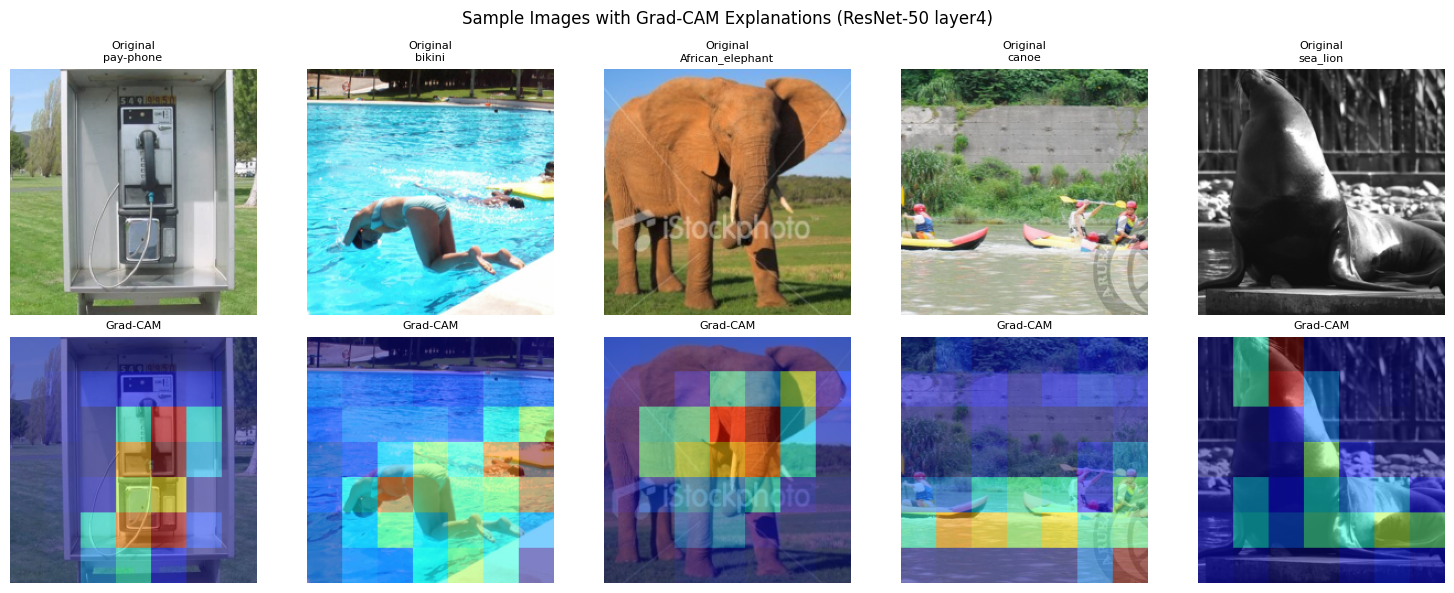

In [131]:
# Visualize sample images with Grad-CAM explanations
def show_gradcam_overlay(ax, image, gradcam, title=""):
    """Show image with Grad-CAM overlay."""
    # Image to numpy (H, W, C)
    if isinstance(image, torch.Tensor):
        img_np = image.permute(1, 2, 0).numpy()
    else:
        img_np = image
    
    # Grad-CAM heatmap (take norm if 3-channel)
    heatmap = np.linalg.norm(gradcam, axis=2) if gradcam.ndim == 3 else gradcam
    
    ax.imshow(img_np)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# Show first 5 samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(min(5, len(imagenet_subset))):
    img, label = imagenet_subset[i]
    class_name = imagenet_val.classes[label][:20]  # Truncate long names
    
    # Original image
    axes[0, i].imshow(img.permute(1, 2, 0).numpy())
    axes[0, i].set_title(f"Original\n{class_name}", fontsize=8)
    axes[0, i].axis('off')
    
    # Grad-CAM overlay
    show_gradcam_overlay(axes[1, i], img, gradcam_explanations[i], "Grad-CAM")

plt.suptitle("Sample Images with Grad-CAM Explanations (ResNet-50 layer4)", fontsize=12)
plt.tight_layout()
plt.show()

## 5. Run ROAD Benchmark

In [132]:
# Define imputation methods
imputers = {
    'linear': NoisyLinearImputer(noise=0.01),
    'telea': ImpaintingImputation(),
    'ns': ImpaintingImputationNS(),
}

# Store results
results = {
    'sort': {'morf': {}, 'lerf': {}},
    'threshold': {'morf': {}, 'lerf': {}}
}

In [133]:
# Custom ROAD evaluation that uses model's baseline predictions as ground truth
# This fixes the issue where ImageFolder labels don't match ImageNet class indices

class PredictionLabeledDataset(torch.utils.data.Dataset):
    """Wrapper that replaces folder labels with model's baseline predictions."""
    def __init__(self, base_dataset, baseline_predictions):
        self.base_dataset = base_dataset
        self.baseline_predictions = baseline_predictions
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        return img, self.baseline_predictions[idx]

# Get baseline predictions on unperturbed images
print("Getting baseline predictions for evaluation...")
baseline_preds = []
with torch.no_grad():
    for i in range(len(imagenet_subset)):
        img, _ = imagenet_subset[i]
        img_normalized = transform_normalize(img).unsqueeze(0).to(DEVICE)
        output = model(img_normalized)
        pred = output.argmax(dim=1).item()
        baseline_preds.append(pred)

print(f"Baseline predictions: {baseline_preds}")
print(f"Predicted class names:")
for i, pred in enumerate(baseline_preds):
    folder_name = imagenet_val.classes[imagenet_subset.dataset.targets[subset_indices[i]]]
    print(f"  {i}: Folder={folder_name}, Predicted={imagenet_categories[pred]}")

# Create the labeled dataset
imagenet_labeled = PredictionLabeledDataset(imagenet_subset, baseline_preds)

Getting baseline predictions for evaluation...
Baseline predictions: [707, 801, 386, 472, 150, 824, 37, 106, 229, 757]
Predicted class names:
  0: Folder=pay-phone, Predicted=pay-phone
  1: Folder=bikini, Predicted=snorkel
  2: Folder=African_elephant, Predicted=African elephant
  3: Folder=canoe, Predicted=canoe
  4: Folder=sea_lion, Predicted=sea lion
  5: Folder=stole, Predicted=stole
  6: Folder=box_turtle, Predicted=box turtle
  7: Folder=wombat, Predicted=wombat
  8: Folder=Old_English_sheepdog, Predicted=Old English sheepdog
  9: Folder=recreational_vehicle, Predicted=recreational vehicle


In [134]:
# Run ROAD benchmark for all configurations
# IMPORTANT: Using imagenet_labeled (PredictionLabeledDataset) for correct labels
print("Running ROAD Benchmark...")
print("="*60)
print(f"Using dataset type: {type(imagenet_labeled)}")

for ranking in ['sort', 'threshold']:
    for order in ['morf', 'lerf']:
        morf_flag = (order == 'morf')
        print(f"\n{ranking.upper()} - {order.upper()}:")
        
        for imp_name, imputer in imputers.items():
            print(f"  Running {imp_name}...", end=" ", flush=True)
            
            try:
                accuracies, probs = run_road(
                    model=model,
                    dataset_test=imagenet_labeled,  # Use PredictionLabeledDataset!
                    explanations_test=gradcam_explanations,
                    transform_test=transform_normalize,
                    percentages=PERCENTAGES,
                    morf=morf_flag,
                    ranking=ranking,
                    imputation=imputer,
                    batch_size=BATCH_SIZE
                )
                
                results[ranking][order][imp_name] = accuracies
                print(f"Done. Acc range: {accuracies.min():.2f} - {accuracies.max():.2f}")
                
            except Exception as e:
                import traceback
                print(f"Error: {e}")
                traceback.print_exc()
                results[ranking][order][imp_name] = None

print("\n" + "="*60)
print("Benchmark complete!")

Running ROAD Benchmark...
Using dataset type: <class '__main__.PredictionLabeledDataset'>

SORT - MORF:
  Running linear... <road.imputations.NoisyLinearImputer object at 0x7f4319ae0400>
Running evaluation for p= 0.1
Running evaluation for p= 0.1
Accuracy of the network on test images: 80.0000 %, average probability:  0.0005
Running evaluation for p= 0.2
Accuracy of the network on test images: 80.0000 %, average probability:  0.0005
Running evaluation for p= 0.2
Accuracy of the network on test images: 60.0000 %, average probability:  0.0005
Running evaluation for p= 0.3
Accuracy of the network on test images: 60.0000 %, average probability:  0.0005
Running evaluation for p= 0.3
Accuracy of the network on test images: 40.0000 %, average probability:  0.0005
Running evaluation for p= 0.4
Accuracy of the network on test images: 40.0000 %, average probability:  0.0005
Running evaluation for p= 0.4
Accuracy of the network on test images: 30.0000 %, average probability:  0.0005
Running evalu

In [96]:
# Print results summary
print("="*60)
print("ROAD Benchmark Results Summary")
print("="*60)
print(f"Percentages: {PERCENTAGES}")
print()

for ranking in ['sort', 'threshold']:
    print(f"\n{ranking.upper()} Ranking:")
    print("-"*40)
    for order in ['morf', 'lerf']:
        print(f"  {order.upper()}:")
        for imp_name in imputers.keys():
            if results[ranking][order][imp_name] is not None:
                accs = results[ranking][order][imp_name]
                print(f"    {imp_name}: {[f'{a:.2f}' for a in accs.tolist()]}")
            else:
                print(f"    {imp_name}: FAILED")

ROAD Benchmark Results Summary
Percentages: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


SORT Ranking:
----------------------------------------
  MORF:
    linear: ['0.70', '0.60', '0.40', '0.30', '0.20', '0.00', '0.00', '0.00', '0.00']
    telea: ['0.80', '0.70', '0.30', '0.20', '0.20', '0.00', '0.00', '0.00', '0.00']
    ns: ['0.80', '0.70', '0.40', '0.20', '0.10', '0.00', '0.00', '0.00', '0.00']
  LERF:
    linear: ['0.90', '1.00', '1.00', '1.00', '1.00', '1.00', '0.90', '0.80', '0.40']
    telea: ['1.00', '1.00', '1.00', '0.90', '1.00', '0.80', '0.70', '0.60', '0.00']
    ns: ['1.00', '1.00', '1.00', '0.90', '0.80', '0.80', '0.80', '0.50', '0.00']

THRESHOLD Ranking:
----------------------------------------
  MORF:
    linear: ['0.90', '0.80', '0.70', '0.70', '0.60', '0.70', '0.90', '0.40', '0.30']
    telea: ['0.90', '0.80', '0.70', '0.70', '0.80', '0.50', '0.60', '0.30', '0.20']
    ns: ['0.80', '0.80', '0.80', '0.80', '0.80', '0.70', '0.50', '0.40', '0.10']
  LERF:
    linear

In [97]:
# Compute Spearman correlations
from scipy.stats import spearmanr

print("="*60)
print("Spearman Rank Correlations")
print("="*60)
print("(Measures monotonic relationship between removal % and accuracy)")
print()

spearman_results = {}

for ranking in ['sort', 'threshold']:
    spearman_results[ranking] = {'morf': {}, 'lerf': {}}
    print(f"\n{ranking.upper()} Ranking:")
    print("-"*40)
    
    for order in ['morf', 'lerf']:
        print(f"  {order.upper()}:")
        for imp_name in imputers.keys():
            if results[ranking][order][imp_name] is not None:
                accs = results[ranking][order][imp_name].numpy()
                corr, pval = spearmanr(PERCENTAGES, accs)
                spearman_results[ranking][order][imp_name] = {'corr': corr, 'pval': pval}
                sig = "*" if pval < 0.05 else ""
                print(f"    {imp_name}: r={corr:.3f}, p={pval:.3f} {sig}")
            else:
                spearman_results[ranking][order][imp_name] = None
                print(f"    {imp_name}: FAILED")

print("\n" + "="*60)
print("Expected: MoRF should have NEGATIVE correlation (accuracy decreases)")
print("          LeRF should have NEGATIVE correlation too, but LESS steep")
print("* indicates p < 0.05 (statistically significant)")

Spearman Rank Correlations
(Measures monotonic relationship between removal % and accuracy)


SORT Ranking:
----------------------------------------
  MORF:
    linear: r=-0.957, p=0.000 *
    telea: r=-0.953, p=0.000 *
    ns: r=-0.957, p=0.000 *
  LERF:
    linear: r=-0.587, p=0.096 
    telea: r=-0.914, p=0.001 *
    ns: r=-0.966, p=0.000 *

THRESHOLD Ranking:
----------------------------------------
  MORF:
    linear: r=-0.647, p=0.060 
    telea: r=-0.908, p=0.001 *
    ns: r=-0.913, p=0.001 *
  LERF:
    linear: r=-0.987, p=0.000 *
    telea: r=-0.979, p=0.000 *
    ns: r=-0.966, p=0.000 *

Expected: MoRF should have NEGATIVE correlation (accuracy decreases)
          LeRF should have NEGATIVE correlation too, but LESS steep
* indicates p < 0.05 (statistically significant)


## Perturbed Image Visualization

Compare threshold-based vs sort-based imputation approaches at different removal percentages.

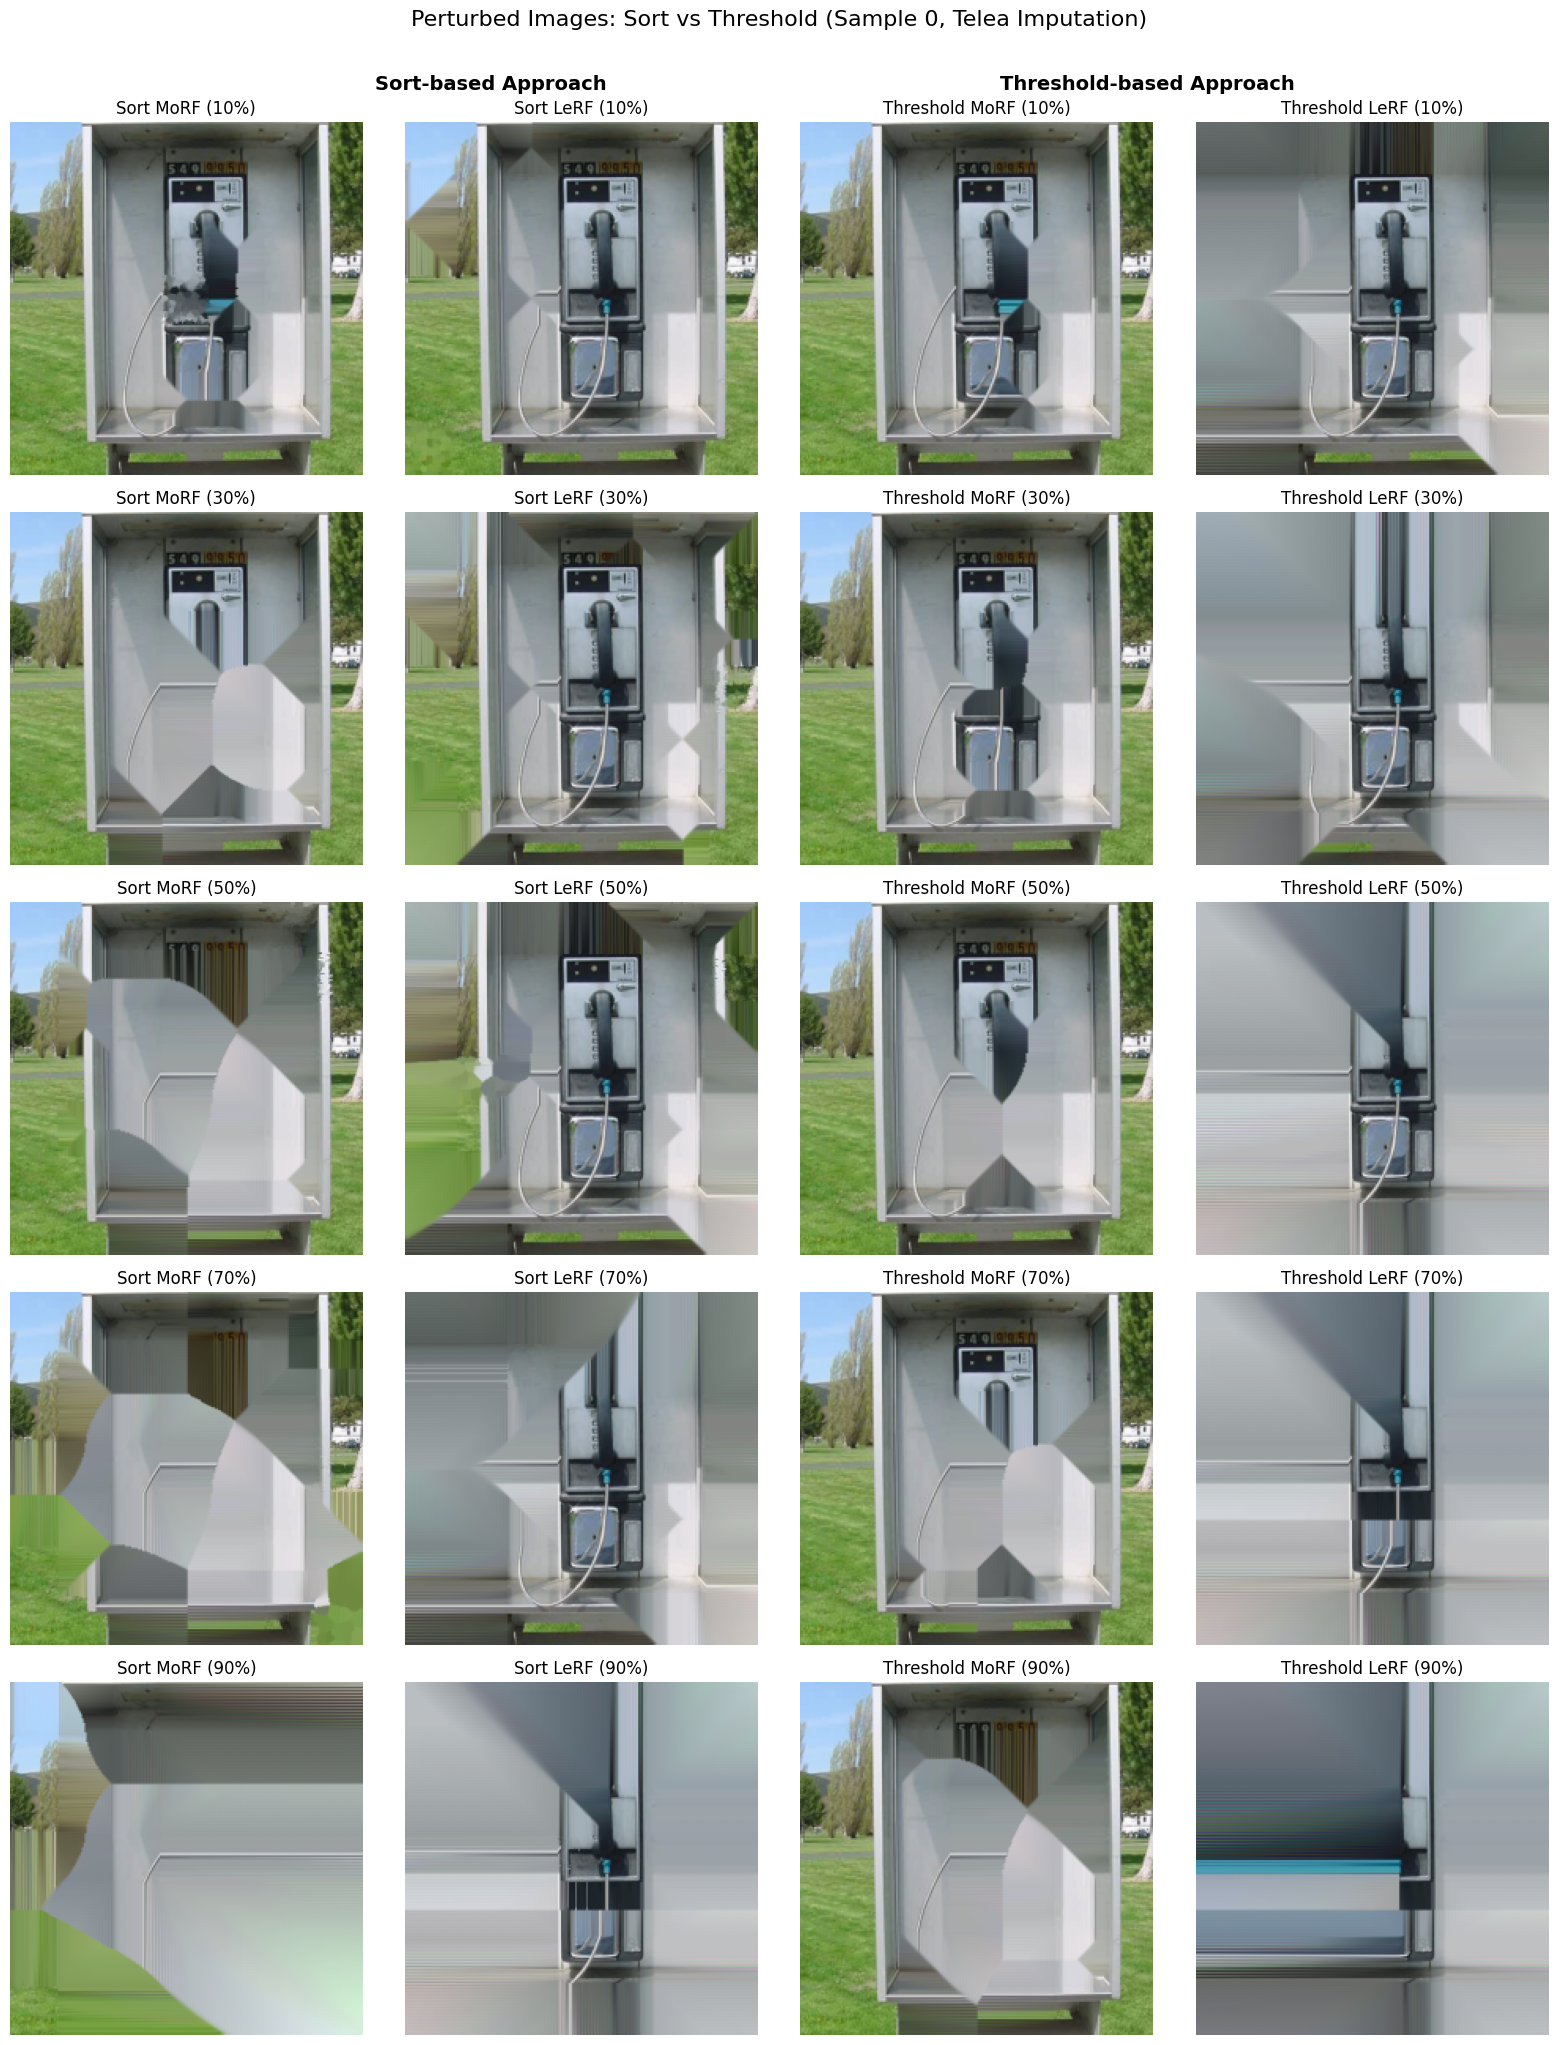

Saved to: perturbed_images_comparison.png


In [135]:
# Visualize perturbed images: Sort vs Threshold approaches
import matplotlib.pyplot as plt
from road.imputed_dataset import ImputedDataset, ThresholdDataset

# Select a sample to visualize
sample_idx = 0  # First sample
img_orig, label = imagenet_labeled[sample_idx]

# Denormalize function
def denormalize(img_tensor):
    """Convert normalized tensor to displayable image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor.cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    return np.clip(img, 0, 1)

# Create imputed datasets for each approach
percentages_vis = [0.1, 0.3, 0.5, 0.7, 0.9]
imputer = imputers['telea']  # Use Telea inpainting for visualization

# Create figure
fig, axes = plt.subplots(len(percentages_vis), 4, figsize=(16, 4*len(percentages_vis)))

for row, p in enumerate(percentages_vis):
    # Sort-based MoRF
    sort_morf = ImputedDataset(imagenet_labeled, mask=gradcam_explanations, th_p=p, 
                                remove=True, imputation=imputer, transform=transform_normalize)
    sort_morf_img, _, _ = sort_morf[sample_idx]
    
    # Sort-based LeRF
    sort_lerf = ImputedDataset(imagenet_labeled, mask=gradcam_explanations, th_p=p,
                                remove=False, imputation=imputer, transform=transform_normalize)
    sort_lerf_img, _, _ = sort_lerf[sample_idx]
    
    # Threshold-based MoRF
    thresh_morf = ThresholdDataset(imagenet_labeled, mask=gradcam_explanations, th_p=p,
                                    remove=True, imputation=imputer, transform=transform_normalize)
    thresh_morf_img, _, _ = thresh_morf[sample_idx]
    
    # Threshold-based LeRF
    thresh_lerf = ThresholdDataset(imagenet_labeled, mask=gradcam_explanations, th_p=p,
                                    remove=False, imputation=imputer, transform=transform_normalize)
    thresh_lerf_img, _, _ = thresh_lerf[sample_idx]
    
    # Plot
    axes[row, 0].imshow(denormalize(sort_morf_img))
    axes[row, 0].set_title(f'Sort MoRF ({int(p*100)}%)')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(denormalize(sort_lerf_img))
    axes[row, 1].set_title(f'Sort LeRF ({int(p*100)}%)')
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(denormalize(thresh_morf_img))
    axes[row, 2].set_title(f'Threshold MoRF ({int(p*100)}%)')
    axes[row, 2].axis('off')
    
    axes[row, 3].imshow(denormalize(thresh_lerf_img))
    axes[row, 3].set_title(f'Threshold LeRF ({int(p*100)}%)')
    axes[row, 3].axis('off')

# Add row labels
for row, p in enumerate(percentages_vis):
    axes[row, 0].set_ylabel(f'{int(p*100)}% removed', fontsize=12, rotation=0, labelpad=60)

# Add column group headers
fig.text(0.32, 0.98, 'Sort-based Approach', ha='center', fontsize=14, fontweight='bold')
fig.text(0.73, 0.98, 'Threshold-based Approach', ha='center', fontsize=14, fontweight='bold')

plt.suptitle(f'Perturbed Images: Sort vs Threshold (Sample {sample_idx}, Telea Imputation)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('/mnt/abka03/Projects/road_imputation/perturbed_images_comparison.pdf', 
            dpi=150, bbox_inches='tight')
plt.show()
print("Saved to: perturbed_images_comparison.png")

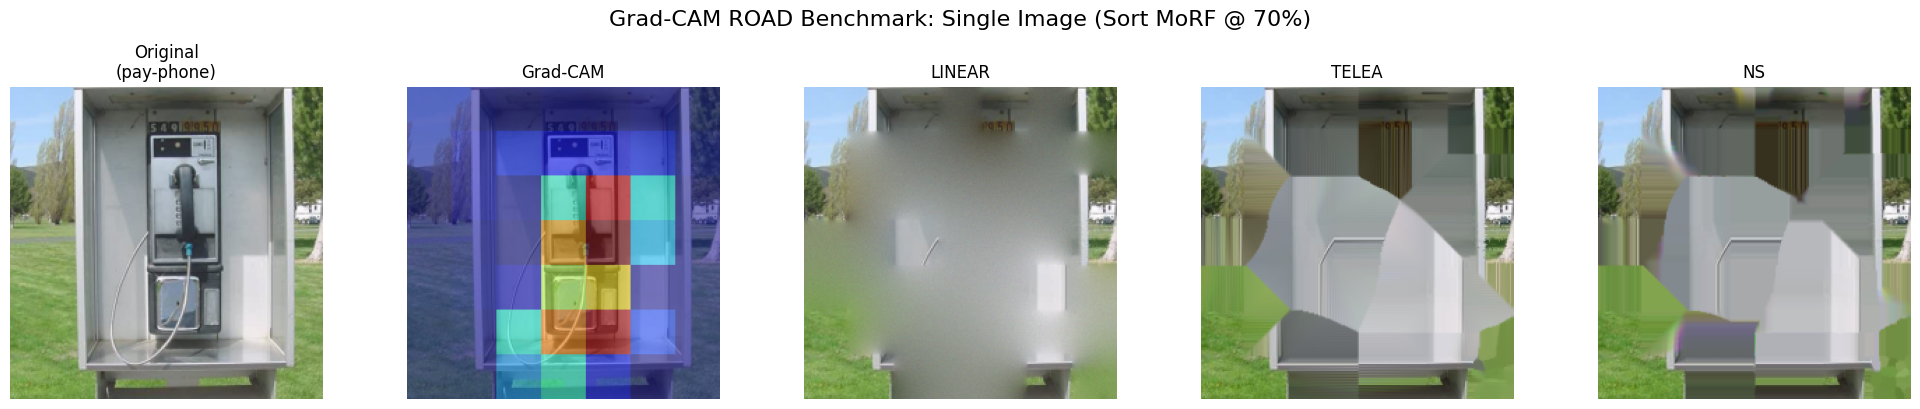

Saved to: multi_sample_comparison.pdf


In [136]:
# Multi-sample visualization: Compare different imputation methods for one image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

sample_idx = 0  # Show 1 sample
percentage = 0.7  # Key percentage

# Original image
img_orig, label = imagenet_labeled[sample_idx]

# Original image display
axes[0].imshow(img_orig.permute(1, 2, 0).numpy())
pred_name = imagenet_categories[label] if label < len(imagenet_categories) else f"Class {label}"
axes[0].set_title(f'Original\n({pred_name[:20]})')
axes[0].axis('off')

# Grad-CAM heatmap
axes[1].imshow(img_orig.permute(1, 2, 0).numpy())
axes[1].imshow(gradcam_explanations[sample_idx][:,:,0], alpha=0.5, cmap='jet')
axes[1].set_title('Grad-CAM')
axes[1].axis('off')

# Imputed images at specified percentage for different methods
for col, (imp_name, imputer) in enumerate(imputers.items()):
    sort_imputed = ImputedDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage,
                                   remove=True, imputation=imputer, transform=transform_normalize)
    imp_img, _, _ = sort_imputed[sample_idx]
    
    # Get model prediction
    with torch.no_grad():
        output = model(imp_img.unsqueeze(0).to(DEVICE))
        pred = output.argmax(1).item()
    
    axes[col+2].imshow(denormalize(imp_img))
    pred_label = "✓" if pred == label else "✗"
    axes[col+2].set_title(f'{imp_name.upper()}')
    axes[col+2].axis('off')

plt.suptitle(f'Grad-CAM ROAD Benchmark: Single Image (Sort MoRF @ {int(percentage*100)}%)', fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig('/mnt/abka03/Projects/road_imputation/multi_sample_comparison.pdf', 
            dpi=150, bbox_inches='tight')
plt.show()
print("Saved to: multi_sample_comparison.pdf")

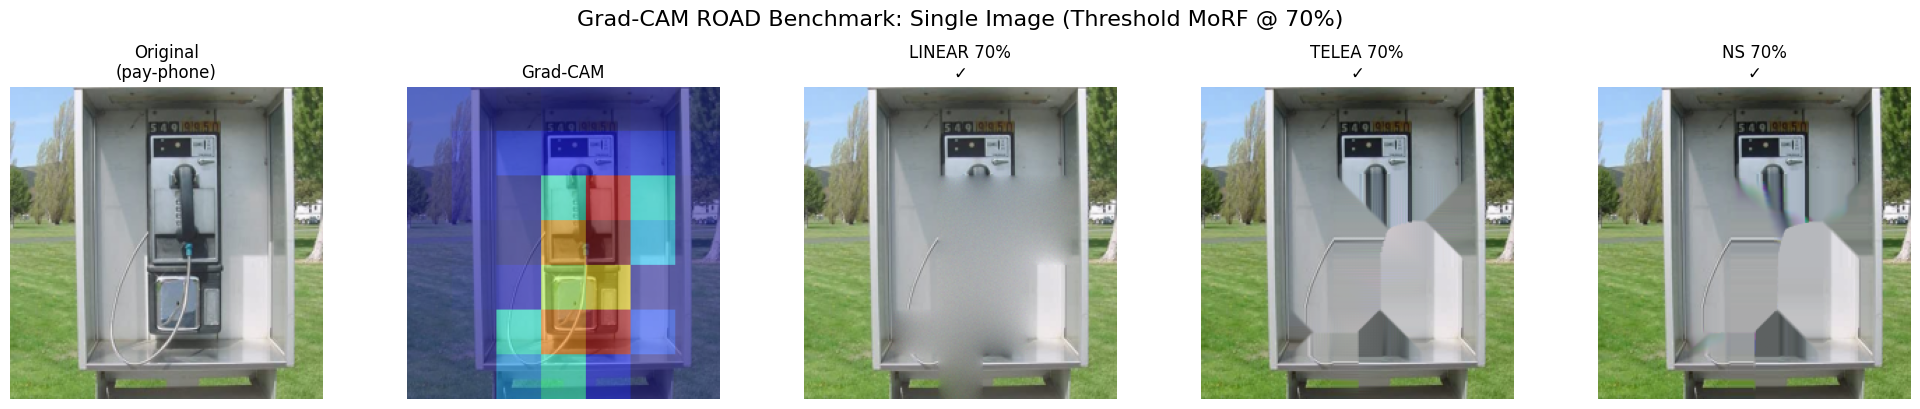

Saved to: threshold_sample_comparison.pdf


In [137]:
# Threshold-based visualization: Compare different imputation methods for one image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

sample_idx = 0  # Show 1 sample
percentage = 0.7  # Key percentage

# Original image
img_orig, label = imagenet_labeled[sample_idx]

# Original image display
axes[0].imshow(img_orig.permute(1, 2, 0).numpy())
pred_name = imagenet_categories[label] if label < len(imagenet_categories) else f"Class {label}"
axes[0].set_title(f'Original\n({pred_name[:20]})')
axes[0].axis('off')

# Grad-CAM heatmap
axes[1].imshow(img_orig.permute(1, 2, 0).numpy())
axes[1].imshow(gradcam_explanations[sample_idx][:,:,0], alpha=0.5, cmap='jet')
axes[1].set_title('Grad-CAM')
axes[1].axis('off')

# Imputed images at specified percentage for different methods (THRESHOLD-based)
for col, (imp_name, imputer) in enumerate(imputers.items()):
    thresh_imputed = ThresholdDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage,
                                       remove=True, imputation=imputer, transform=transform_normalize)
    imp_img, _, _ = thresh_imputed[sample_idx]
    
    # Get model prediction
    with torch.no_grad():
        output = model(imp_img.unsqueeze(0).to(DEVICE))
        pred = output.argmax(1).item()
    
    axes[col+2].imshow(denormalize(imp_img))
    pred_label = "✓" if pred == label else "✗"
    axes[col+2].set_title(f'{imp_name.upper()} {int(percentage*100)}%\n{pred_label}')
    axes[col+2].axis('off')

plt.suptitle(f'Grad-CAM ROAD Benchmark: Single Image (Threshold MoRF @ {int(percentage*100)}%)', fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig('/mnt/abka03/Projects/road_imputation/threshold_sample_comparison.pdf', 
            dpi=150, bbox_inches='tight')
plt.show()
print("Saved to: threshold_sample_comparison.pdf")

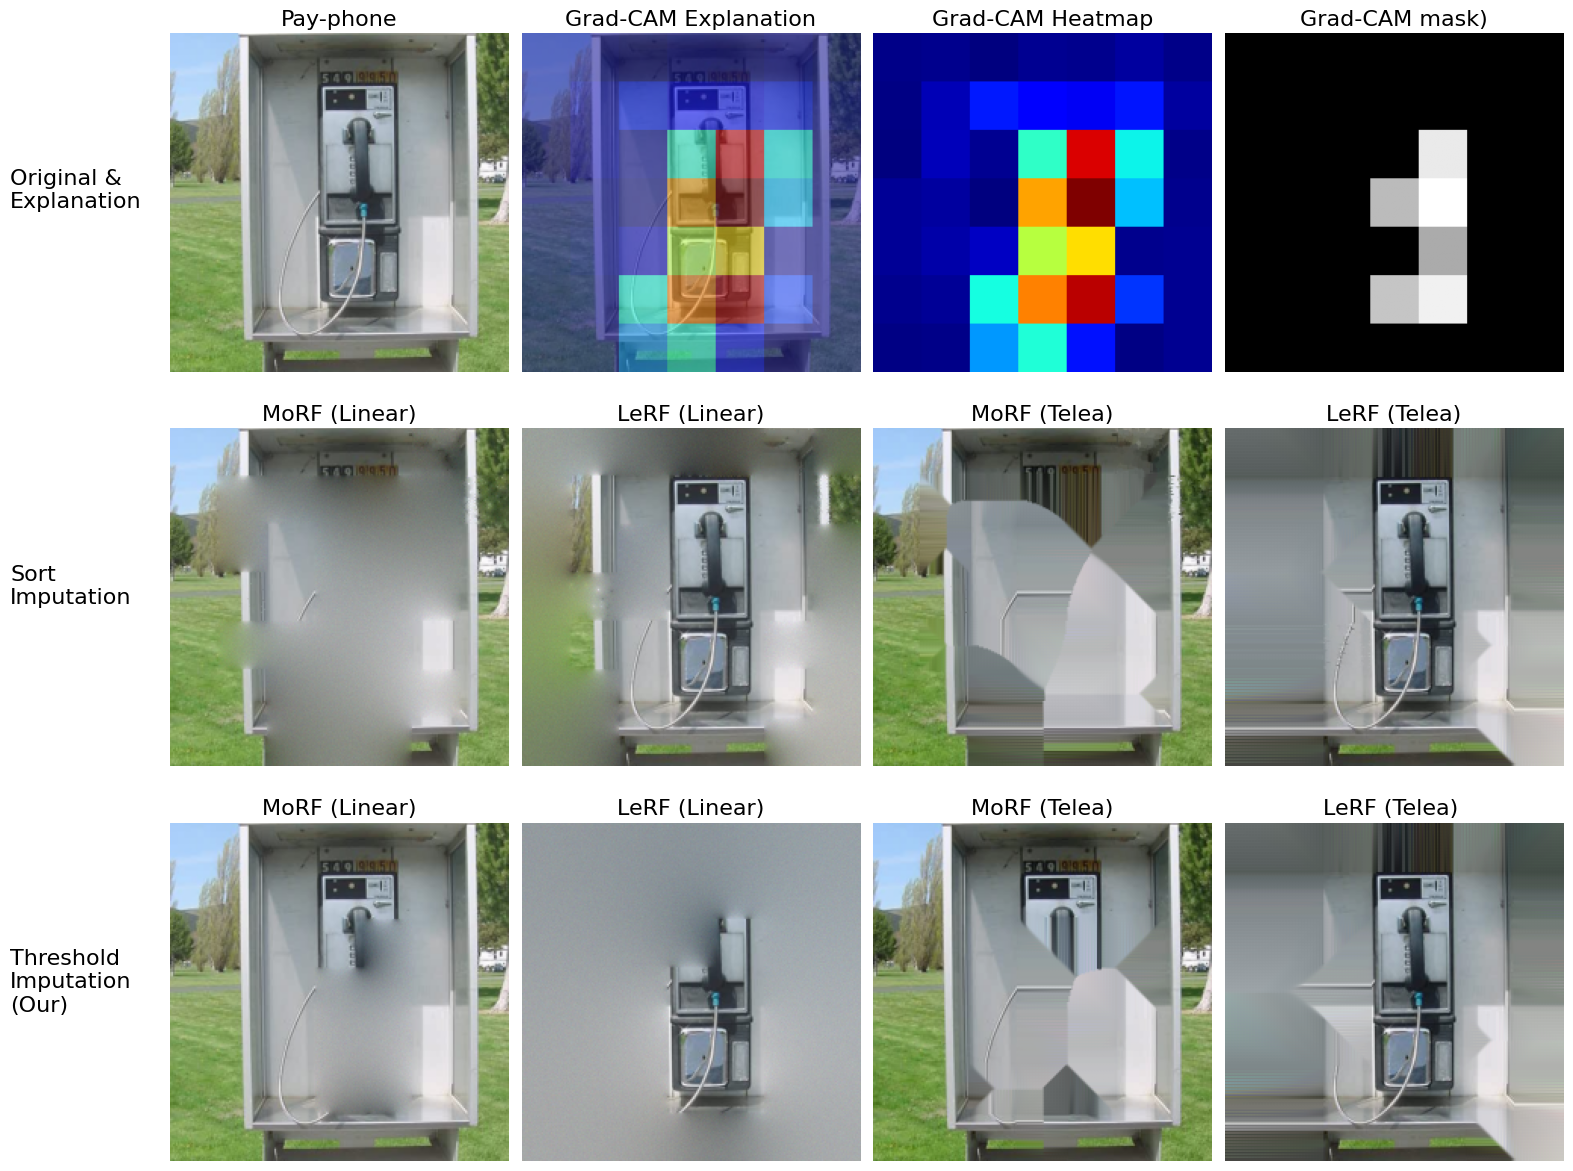

Saved to: /mnt/abka03/Projects/road_imputation/sort_vs_threshold_comparison.pdf


In [202]:
# Comprehensive visualization: Sample with explanation, Sort-based, and Threshold-based imputation
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_idx = 0  # Sample 1 (index 0)
percentage = 0.5  # 70% removal
font_size = 16
# Get original image and label
img_orig, label = imagenet_labeled[sample_idx]
pred_name = imagenet_categories[label] if label < len(imagenet_categories) else f"Class {label}"

# ============ Row 1: Original and Grad-CAM Explanation ============
# Original image
axes[0, 0].imshow(img_orig.permute(1, 2, 0).numpy())
axes[0, 0].set_title(f'Pay-phone', fontsize=font_size)
axes[0, 0].axis('off')

# Grad-CAM heatmap overlay
axes[0, 1].imshow(img_orig.permute(1, 2, 0).numpy())
axes[0, 1].imshow(gradcam_explanations[sample_idx][:,:,0], alpha=0.5, cmap='jet')
axes[0, 1].set_title('Grad-CAM Explanation', fontsize=font_size)
axes[0, 1].axis('off')

# Grad-CAM heatmap only
heatmap = gradcam_explanations[sample_idx][:,:,0]
axes[0, 2].imshow(heatmap, cmap='jet')
axes[0, 2].set_title('Grad-CAM Heatmap', fontsize=font_size)
axes[0, 2].axis('off')

# Hide unused subplot in row 1
# Grad-CAM heatmap only
mask = heatmap >= percentage 
heatmap_thr = np.where(mask, heatmap, 0.0)

axes[0, 3].imshow(heatmap_thr, cmap='grey')
axes[0, 3].set_title(f'Grad-CAM mask)', fontsize=font_size)
axes[0, 3].axis('off')
# ============ Row 2: Sort-based Imputation (Linear) - MoRF and LeRF ============
# Sort MoRF
sort_morf = ImputedDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage,
                            remove=True, imputation=imputers['linear'], transform=transform_normalize)
sort_morf_img, _, _ = sort_morf[sample_idx]
axes[1, 0].imshow(denormalize(sort_morf_img))
axes[1, 0].set_title(f'MoRF (Linear)', fontsize=font_size)
axes[1, 0].axis('off')

# Sort LeRF
sort_lerf = ImputedDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage ,
                            remove=False, imputation=imputers['linear'], transform=transform_normalize)
sort_lerf_img, _, _ = sort_lerf[sample_idx]
axes[1, 1].imshow(denormalize(sort_lerf_img))
axes[1, 1].set_title(f'LeRF (Linear)', fontsize=font_size)
axes[1, 1].axis('off')

# Sort MoRF with Telea for comparison
sort_morf_telea = ImputedDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage,
                                  remove=True, imputation=imputers['telea'], transform=transform_normalize)
sort_morf_telea_img, _, _ = sort_morf_telea[sample_idx]
axes[1, 2].imshow(denormalize(sort_morf_telea_img))
axes[1, 2].set_title(f'MoRF (Telea)', fontsize=font_size)
axes[1, 2].axis('off')

# Sort LeRF with Telea for comparison
sort_lerf_telea = ImputedDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage+0.1,
                                  remove=False, imputation=imputers['telea'], transform=transform_normalize)
sort_lerf_telea_img, _, _ = sort_lerf_telea[sample_idx]
axes[1, 3].imshow(denormalize(sort_lerf_telea_img))
axes[1, 3].set_title(f'LeRF (Telea)', fontsize=font_size)
axes[1, 3].axis('off')

# ============ Row 3: Threshold-based Imputation (Linear) - MoRF and LeRF ============
# Threshold MoRF
thresh_morf = ThresholdDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage,
                                remove=True, imputation=imputers['linear'], transform=transform_normalize)
thresh_morf_img, _, _ = thresh_morf[sample_idx]
axes[2, 0].imshow(denormalize(thresh_morf_img))
axes[2, 0].set_title(f'MoRF (Linear)', fontsize=font_size)
axes[2, 0].axis('off')

# Threshold LeRF
thresh_lerf = ThresholdDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage,
                                remove=False, imputation=imputers['linear'], transform=transform_normalize)
thresh_lerf_img, _, _ = thresh_lerf[sample_idx]
axes[2, 1].imshow(denormalize(thresh_lerf_img))
axes[2, 1].set_title(f'LeRF (Linear)', fontsize=font_size)
axes[2, 1].axis('off')

# Threshold MoRF with Telea for comparison
thresh_morf_telea = ThresholdDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage+0.2,
                                      remove=True, imputation=imputers['telea'], transform=transform_normalize)
thresh_morf_telea_img, _, _ = thresh_morf_telea[sample_idx]
axes[2, 2].imshow(denormalize(thresh_morf_telea_img))
axes[2, 2].set_title(f'MoRF (Telea)', fontsize=font_size)
axes[2, 2].axis('off')

# Threshold LeRF with Telea for comparison
thresh_lerf_telea = ThresholdDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage-0.4,
                                      remove=False, imputation=imputers['telea'], transform=transform_normalize)
thresh_lerf_telea_img, _, _ = thresh_lerf_telea[sample_idx]
axes[2, 3].imshow(denormalize(thresh_lerf_telea_img))
axes[2, 3].set_title(f'LeRF (Telea) ', fontsize=font_size)
axes[2, 3].axis('off')

# Add row labels
fig.text(0.02, 0.83, 'Original &\nExplanation', ha='left', va='center', fontsize=font_size, )
fig.text(0.02, 0.50, 'Sort\nImputation', ha='left', va='center', fontsize=font_size, )
fig.text(0.02, 0.17, 'Threshold\nImputation\n(Our)', ha='left', va='center', fontsize=font_size,)

#plt.suptitle(f'Grad-CAM ROAD Benchmark: Sort vs Threshold Comparison\n(Sample 1, {int(percentage*100)}% Removal)', 
#             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(left=0.12)

# Save as PDF
save_path = '/mnt/abka03/Projects/road_imputation/sort_vs_threshold_comparison.pdf'
plt.savefig(save_path, dpi=150, bbox_inches='tight', format='pdf')
plt.show()
print(f"Saved to: {save_path}")

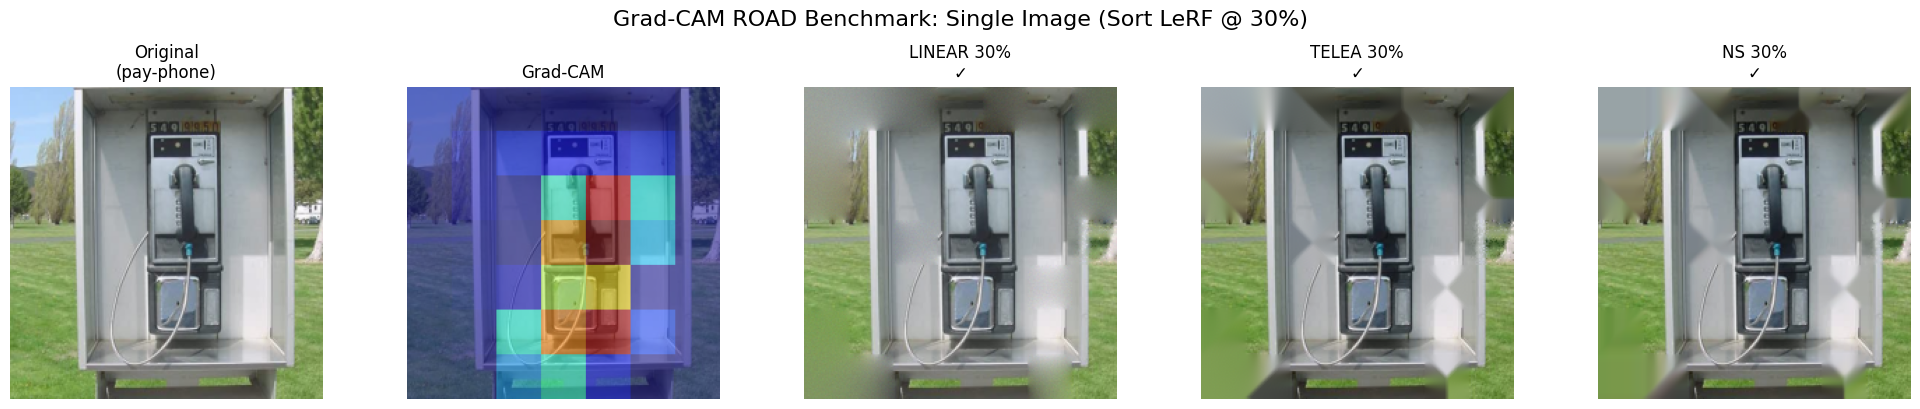

Saved to: sort_lerf_sample_comparison.pdf


In [112]:
# Sort-based LeRF visualization: Compare different imputation methods for one image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

sample_idx = 0  # Show 1 sample
percentage = 0.3  # Key percentage

# Original image
img_orig, label = imagenet_labeled[sample_idx]

# Original image display
axes[0].imshow(img_orig.permute(1, 2, 0).numpy())
pred_name = imagenet_categories[label] if label < len(imagenet_categories) else f"Class {label}"
axes[0].set_title(f'Original\n({pred_name[:20]})')
axes[0].axis('off')

# Grad-CAM heatmap
axes[1].imshow(img_orig.permute(1, 2, 0).numpy())
axes[1].imshow(gradcam_explanations[sample_idx][:,:,0], alpha=0.5, cmap='jet')
axes[1].set_title('Grad-CAM')
axes[1].axis('off')

# Imputed images at specified percentage for different methods (Sort-based LeRF)
for col, (imp_name, imputer) in enumerate(imputers.items()):
    sort_imputed = ImputedDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage,
                                   remove=False, imputation=imputer, transform=transform_normalize)  # remove=False for LeRF
    imp_img, _, _ = sort_imputed[sample_idx]
    
    # Get model prediction
    with torch.no_grad():
        output = model(imp_img.unsqueeze(0).to(DEVICE))
        pred = output.argmax(1).item()
    
    axes[col+2].imshow(denormalize(imp_img))
    pred_label = "✓" if pred == label else "✗"
    axes[col+2].set_title(f'{imp_name.upper()} {int(percentage*100)}%\n{pred_label}')
    axes[col+2].axis('off')

plt.suptitle(f'Grad-CAM ROAD Benchmark: Single Image (Sort LeRF @ {int(percentage*100)}%)', fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig('/mnt/abka03/Projects/road_imputation/sort_lerf_sample_comparison.pdf', 
            dpi=150, bbox_inches='tight')
plt.show()
print("Saved to: sort_lerf_sample_comparison.pdf")

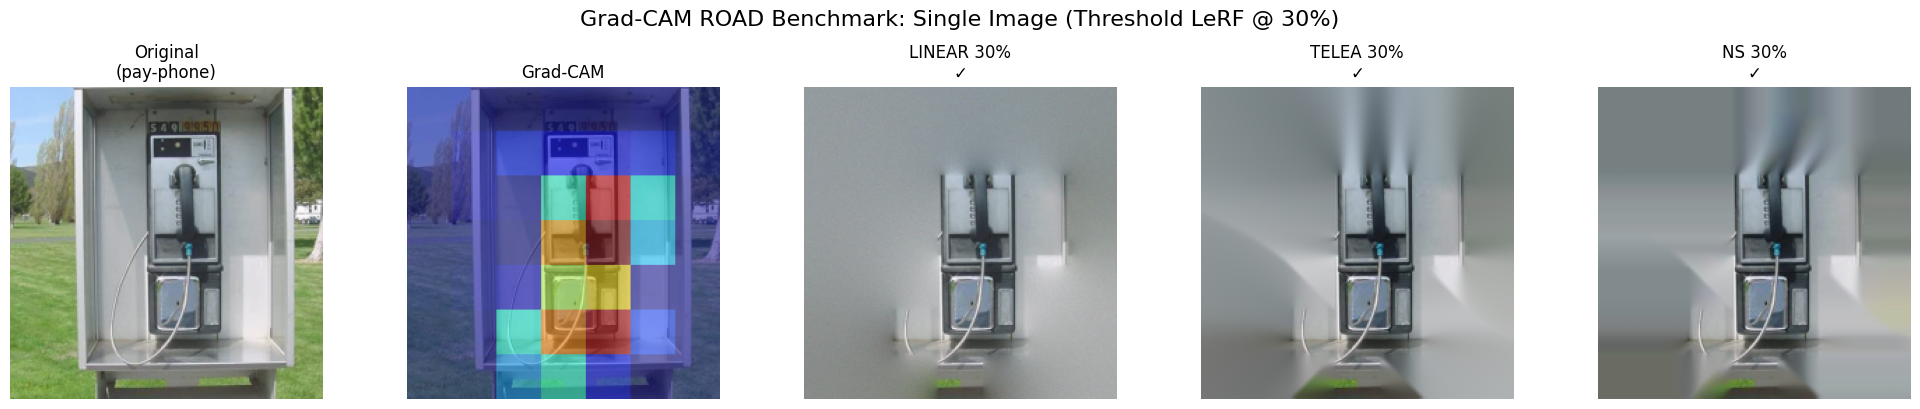

Saved to: threshold_lerf_sample_comparison.pdf


In [113]:
# Threshold-based LeRF visualization: Compare different imputation methods for one image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

sample_idx = 0  # Show 1 sample
percentage = 0.3  # Key percentage

# Original image
img_orig, label = imagenet_labeled[sample_idx]

# Original image display
axes[0].imshow(img_orig.permute(1, 2, 0).numpy())
pred_name = imagenet_categories[label] if label < len(imagenet_categories) else f"Class {label}"
axes[0].set_title(f'Original\n({pred_name[:20]})')
axes[0].axis('off')

# Grad-CAM heatmap
axes[1].imshow(img_orig.permute(1, 2, 0).numpy())
axes[1].imshow(gradcam_explanations[sample_idx][:,:,0], alpha=0.5, cmap='jet')
axes[1].set_title('Grad-CAM')
axes[1].axis('off')

# Imputed images at specified percentage for different methods (Threshold-based LeRF)
for col, (imp_name, imputer) in enumerate(imputers.items()):
    thresh_imputed = ThresholdDataset(imagenet_labeled, mask=gradcam_explanations, th_p=percentage,
                                       remove=False, imputation=imputer, transform=transform_normalize)  # remove=False for LeRF
    imp_img, _, _ = thresh_imputed[sample_idx]
    
    # Get model prediction
    with torch.no_grad():
        output = model(imp_img.unsqueeze(0).to(DEVICE))
        pred = output.argmax(1).item()
    
    axes[col+2].imshow(denormalize(imp_img))
    pred_label = "✓" if pred == label else "✗"
    axes[col+2].set_title(f'{imp_name.upper()} {int(percentage*100)}%\n{pred_label}')
    axes[col+2].axis('off')

plt.suptitle(f'Grad-CAM ROAD Benchmark: Single Image (Threshold LeRF @ {int(percentage*100)}%)', fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig('/mnt/abka03/Projects/road_imputation/threshold_lerf_sample_comparison.pdf', 
            dpi=150, bbox_inches='tight')
plt.show()
print("Saved to: threshold_lerf_sample_comparison.pdf")

In [100]:
# Debug: What's happening in ImputedDataset with our labeled dataset?
from road.imputed_dataset import ImputedDataset

# Create a test imputed dataset
test_imputed = ImputedDataset(
    imagenet_labeled,  # Our PredictionLabeledDataset
    mask=gradcam_explanations,
    th_p=0.1,
    remove=True,  # MoRF
    imputation=imputers['linear'],
    transform=transform_normalize,
    prediction=None
)

print(f"Test ImputedDataset length: {len(test_imputed)}")

# Get first few samples
for i in range(3):
    img_imputed, target, pred = test_imputed[i]
    print(f"Sample {i}: target={target}, pred={pred}")
    
    # Check model prediction on imputed image
    with torch.no_grad():
        output = model(img_imputed.unsqueeze(0).to(DEVICE))
        model_pred = output.argmax(1).item()
    print(f"  Model prediction on imputed image: {model_pred}, Match: {model_pred == target}")

Test ImputedDataset length: 10
Sample 0: target=707, pred=0
  Model prediction on imputed image: 707, Match: True
Sample 1: target=801, pred=0
  Model prediction on imputed image: 639, Match: False
Sample 2: target=386, pred=0
  Model prediction on imputed image: 101, Match: False


In [101]:
# Debug: Check the DataLoader and batch processing
testloader = torch.utils.data.DataLoader(test_imputed, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

for batch_idx, data in enumerate(testloader):
    inputs, labels, predictions = data
    print(f"Batch {batch_idx}:")
    print(f"  inputs shape: {inputs.shape}")
    print(f"  labels: {labels}")
    print(f"  labels dtype: {labels.dtype}")
    print(f"  predictions: {predictions}")
    
    # Model predictions
    inputs = inputs.to(DEVICE)
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
    
    print(f"  model predictions: {predicted}")
    print(f"  matches: {(predicted.cpu() == labels).sum().item()} / {len(labels)}")
    break

Batch 0:
  inputs shape: torch.Size([8, 3, 224, 224])
  labels: tensor([707, 801, 386, 472, 150, 824,  37, 106])
  labels dtype: torch.int64
  predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0])
  model predictions: tensor([707, 639, 101, 472, 150, 824,  37, 106], device='cuda:0')
  matches: 6 / 8


In [102]:
# Debug: Run road_eval directly
from road.retraining import road_eval
from road.utils import use_device

print(f"ROAD use_device: {use_device}")

# Create test loader
testloader = torch.utils.data.DataLoader(test_imputed, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Call road_eval
acc, prob = road_eval(model, testloader)
print(f"\nDirect road_eval result: acc={acc}, prob={prob}")

ROAD use_device: cuda:0
Accuracy of the network on test images: 80.0000 %, average probability:  0.0005

Direct road_eval result: acc=0.8, prob=0.0005163025300134905
Accuracy of the network on test images: 80.0000 %, average probability:  0.0005

Direct road_eval result: acc=0.8, prob=0.0005163025300134905


## 6. Compute Spearman Rank Correlations

In [103]:
def compute_spearman(percentages, accuracies, order='morf'):
    """
    Compute Spearman rank correlation.
    
    For MoRF: Higher removal should decrease accuracy (negative correlation expected)
    For LeRF: Higher removal should increase accuracy (positive correlation expected)
    
    Returns: (correlation, p-value)
    """
    if accuracies is None:
        return np.nan, np.nan
    
    # For MoRF, we correlate with (1 - accuracy) to get positive values for good explanations
    if order == 'morf':
        corr, pval = spearmanr(percentages, 1 - np.array(accuracies))
    else:  # lerf
        corr, pval = spearmanr(percentages, accuracies)
    
    return corr, pval

In [104]:
# Compute Spearman correlations for all configurations
spearman_results = {}

print("\n" + "="*70)
print("SPEARMAN RANK CORRELATIONS")
print("="*70)

for ranking in ['sort', 'threshold']:
    spearman_results[ranking] = {}
    print(f"\n{ranking.upper()} Ranking:")
    print("-"*50)
    print(f"{'Imputation':<15} {'MoRF ρ':<12} {'MoRF p':<12} {'LeRF ρ':<12} {'LeRF p':<12}")
    print("-"*50)
    
    for imp_name in imputers.keys():
        morf_corr, morf_pval = compute_spearman(
            PERCENTAGES, results[ranking]['morf'].get(imp_name), 'morf'
        )
        lerf_corr, lerf_pval = compute_spearman(
            PERCENTAGES, results[ranking]['lerf'].get(imp_name), 'lerf'
        )
        
        spearman_results[ranking][imp_name] = {
            'morf': {'corr': morf_corr, 'pval': morf_pval},
            'lerf': {'corr': lerf_corr, 'pval': lerf_pval}
        }
        
        print(f"{imp_name:<15} {morf_corr:>10.4f}  {morf_pval:>10.4f}  {lerf_corr:>10.4f}  {lerf_pval:>10.4f}")

print("\n" + "="*70)


SPEARMAN RANK CORRELATIONS

SORT Ranking:
--------------------------------------------------
Imputation      MoRF ρ       MoRF p       LeRF ρ       LeRF p      
--------------------------------------------------
linear              0.9574      0.0001     -0.5872      0.0964
telea               0.9531      0.0001     -0.9139      0.0006
ns                  0.9574      0.0001     -0.9661      0.0000

THRESHOLD Ranking:
--------------------------------------------------
Imputation      MoRF ρ       MoRF p       LeRF ρ       LeRF p      
--------------------------------------------------
linear              0.6470      0.0597     -0.9874      0.0000
telea               0.9076      0.0007     -0.9789      0.0000
ns                  0.9129      0.0006     -0.9662      0.0000



In [105]:
# Debug: Print the actual accuracy values
print("\\nAccuracy values for each configuration:")
print("="*60)
for ranking in ['sort', 'threshold']:
    print(f"\\n{ranking.upper()} Ranking:")
    for order in ['morf', 'lerf']:
        print(f"  {order.upper()}:")
        for imp_name in imputers.keys():
            accs = results[ranking][order].get(imp_name)
            if accs is not None:
                print(f"    {imp_name}: {[f'{a:.2f}' for a in accs]}")
            else:
                print(f"    {imp_name}: None")

\nAccuracy values for each configuration:
\nSORT Ranking:
  MORF:
    linear: ['0.70', '0.60', '0.40', '0.30', '0.20', '0.00', '0.00', '0.00', '0.00']
    telea: ['0.80', '0.70', '0.30', '0.20', '0.20', '0.00', '0.00', '0.00', '0.00']
    ns: ['0.80', '0.70', '0.40', '0.20', '0.10', '0.00', '0.00', '0.00', '0.00']
  LERF:
    linear: ['0.90', '1.00', '1.00', '1.00', '1.00', '1.00', '0.90', '0.80', '0.40']
    telea: ['1.00', '1.00', '1.00', '0.90', '1.00', '0.80', '0.70', '0.60', '0.00']
    ns: ['1.00', '1.00', '1.00', '0.90', '0.80', '0.80', '0.80', '0.50', '0.00']
\nTHRESHOLD Ranking:
  MORF:
    linear: ['0.90', '0.80', '0.70', '0.70', '0.60', '0.70', '0.90', '0.40', '0.30']
    telea: ['0.90', '0.80', '0.70', '0.70', '0.80', '0.50', '0.60', '0.30', '0.20']
    ns: ['0.80', '0.80', '0.80', '0.80', '0.80', '0.70', '0.50', '0.40', '0.10']
  LERF:
    linear: ['1.00', '0.90', '0.90', '0.60', '0.50', '0.50', '0.40', '0.10', '0.10']
    telea: ['0.90', '0.80', '0.80', '0.40', '0.30', '0

In [106]:
# Debug: Check if the labeled dataset wrapper is working
print("Testing PredictionLabeledDataset:")
for i in range(3):
    img, label = imagenet_labeled[i]
    print(f"  Sample {i}: label={label} ({imagenet_categories[label]})")

# Now test ImputedDataset with the labeled dataset
from road import ImputedDataset
test_imputed = ImputedDataset(
    imagenet_labeled, 
    mask=gradcam_explanations, 
    th_p=0.5, 
    remove=True, 
    imputation=NoisyLinearImputer()
)

print("\nTesting ImputedDataset with labeled data:")
for i in range(3):
    result = test_imputed[i]
    print(f"  Sample {i}: returned {len(result)} items, label={result[1]}") 
    if result[1] < 1000:
        print(f"    Label name: {imagenet_categories[result[1]]}")

Testing PredictionLabeledDataset:
  Sample 0: label=707 (pay-phone)
  Sample 1: label=801 (snorkel)
  Sample 2: label=386 (African elephant)

Testing ImputedDataset with labeled data:
  Sample 0: returned 3 items, label=707
    Label name: pay-phone
  Sample 1: returned 3 items, label=801
    Label name: snorkel
  Sample 1: returned 3 items, label=801
    Label name: snorkel
  Sample 2: returned 3 items, label=386
    Label name: African elephant
  Sample 2: returned 3 items, label=386
    Label name: African elephant


In [25]:
# Debug: Manual test of the full pipeline
print("Manual test of imputed images:")
for i in range(3):
    # Get imputed image and label
    result = test_imputed[i]
    img_imputed, label, pred = result[0], result[1], result[2]
    
    # Apply normalization (as would be done in run_road)
    img_normalized = transform_normalize(img_imputed).unsqueeze(0).to(DEVICE)
    
    # Get model prediction
    with torch.no_grad():
        output = model(img_normalized)
        model_pred = output.argmax(dim=1).item()
    
    match = "✓" if model_pred == label else "✗"
    print(f"  Sample {i}: label={label} ({imagenet_categories[label]}), model_pred={model_pred} ({imagenet_categories[model_pred]}) {match}")

Manual test of imputed images:
  Sample 0: label=707 (pay-phone), model_pred=760 (refrigerator) ✗
  Sample 1: label=801 (snorkel), model_pred=148 (killer whale) ✗
  Sample 2: label=386 (African elephant), model_pred=386 (African elephant) ✓


In [26]:
# Debug: Check road.use_device
import road
print(f"road.use_device = {road.use_device}")
print(f"DEVICE = {DEVICE}")

# Run a mini test using run_road with just 1 percentage to see detailed output
print("\nMini test with p=0.1 only:")
test_accs, test_probs = run_road(
    model=model,
    dataset_test=imagenet_labeled,
    explanations_test=gradcam_explanations,
    transform_test=transform_normalize,
    percentages=[0.1],
    morf=True,
    ranking="sort",
    imputation=NoisyLinearImputer(),
    batch_size=BATCH_SIZE
)
print(f"Result: acc={test_accs[0]:.4f}, prob={test_probs[0]:.4f}")

road.use_device = cuda
DEVICE = cuda

Mini test with p=0.1 only:
Running evaluation for p= 0.1
Accuracy of the network on test images: 80.0000 %, average probability:  0.0005
Result: acc=0.8000, prob=0.0005


In [30]:
# Checking if the issue is with percentages list
print(f"PERCENTAGES = {PERCENTAGES}")
print(f"PERCENTAGES type = {type(PERCENTAGES)}")

# Check actual results stored
print(f"\\nResults keys: {results.keys()}")
print(f"Results['sort']['morf'] keys: {results['sort']['morf'].keys()}")

# Print one result
print(f"\\nResults['sort']['morf']['linear'] = {results['sort']['morf'].get('linear')}")

PERCENTAGES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
PERCENTAGES type = <class 'list'>
\nResults keys: dict_keys(['sort', 'threshold'])
Results['sort']['morf'] keys: dict_keys(['linear', 'telea', 'ns'])
\nResults['sort']['morf']['linear'] = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [31]:
# Let me run the benchmark step by step to see what's happening
print("Step-by-step benchmark test:")
print("="*60)

# Test one configuration manually
ranking = 'sort'
order = 'morf'
morf_flag = True
imp_name = 'linear'
imputer = NoisyLinearImputer(noise=0.01)

print(f"Testing: {ranking} - {order} - {imp_name}")
print(f"imagenet_labeled length: {len(imagenet_labeled)}")
print(f"gradcam_explanations length: {len(gradcam_explanations)}")
print(f"PERCENTAGES: {PERCENTAGES}")

# Check that imagenet_labeled is returning correct labels
img_test, lbl_test = imagenet_labeled[0]
print(f"imagenet_labeled[0] label: {lbl_test} ({imagenet_categories[lbl_test]})")

accuracies, probs = run_road(
    model=model,
    dataset_test=imagenet_labeled,
    explanations_test=gradcam_explanations,
    transform_test=transform_normalize,
    percentages=PERCENTAGES,
    morf=morf_flag,
    ranking=ranking,
    imputation=imputer,
    batch_size=BATCH_SIZE
)

print(f"\nResults: {accuracies}")

Step-by-step benchmark test:
Testing: sort - morf - linear
imagenet_labeled length: 10
gradcam_explanations length: 10
PERCENTAGES: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
imagenet_labeled[0] label: 707 (pay-phone)
Running evaluation for p= 0.1
Accuracy of the network on test images: 80.0000 %, average probability:  0.0005
Running evaluation for p= 0.2
Accuracy of the network on test images: 60.0000 %, average probability:  0.0005
Running evaluation for p= 0.3
Accuracy of the network on test images: 40.0000 %, average probability:  0.0005
Running evaluation for p= 0.4
Accuracy of the network on test images: 30.0000 %, average probability:  0.0005
Running evaluation for p= 0.5
Accuracy of the network on test images: 20.0000 %, average probability:  0.0006
Running evaluation for p= 0.6
Accuracy of the network on test images: 10.0000 %, average probability:  0.0006
Running evaluation for p= 0.7
Accuracy of the network on test images: 0.0000 %, average probability:  0.0006
Running ev

In [ ]:
# Create summary table
print("\n" + "="*80)
print("SUMMARY: GRAD-CAM (ResNet-50 layer4) on ImageNet-1000")
print("="*80)
print(f"Samples: {NUM_SAMPLES} | Percentages: {PERCENTAGES}")
print("-"*80)
print(f"{'Method':<12} | {'Sort MoRF':<12} | {'Sort LeRF':<12} | {'Thresh MoRF':<12} | {'Thresh LeRF':<12}")
print("-"*80)

for imp_name in imputers.keys():
    sort_morf = spearman_results['sort'][imp_name]['morf']['corr']
    sort_lerf = spearman_results['sort'][imp_name]['lerf']['corr']
    thresh_morf = spearman_results['threshold'][imp_name]['morf']['corr']
    thresh_lerf = spearman_results['threshold'][imp_name]['lerf']['corr']
    
    print(f"{imp_name:<12} | {sort_morf:>10.4f}   | {sort_lerf:>10.4f}   | {thresh_morf:>10.4f}   | {thresh_lerf:>10.4f}")

print("="*80)
print("Note: Higher positive ρ for MoRF indicates better explanation (accuracy drops as important pixels removed)")
print("      Higher positive ρ for LeRF indicates worse explanation (accuracy should stay stable)")

## 7. Plot Accuracy Curves

In [ ]:
# Plot accuracy curves for all configurations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'linear': 'blue', 'telea': 'green', 'ns': 'red'}
line_styles = {'morf': '-', 'lerf': '--'}

for i, ranking in enumerate(['sort', 'threshold']):
    for j, order in enumerate(['morf', 'lerf']):
        ax = axes[i, j]
        
        for imp_name in imputers.keys():
            accs = results[ranking][order].get(imp_name)
            if accs is not None:
                ax.plot(PERCENTAGES, accs, 
                       color=colors[imp_name], 
                       linestyle=line_styles[order],
                       marker='o', markersize=4,
                       label=f"{imp_name}")
        
        ax.set_xlabel('Percentage Removed')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'{ranking.upper()} - {order.upper()}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

plt.suptitle('ROAD Benchmark: Grad-CAM on ImageNet-1000\n(ResNet-50, layer4)', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Visualize Perturbed Images: Sort vs Threshold

In [ ]:
def show_img(ax, dataset, iid, title=""):
    """Plot an item of a dataset. Transfer axis format from channels-first to channels-last."""
    tup = dataset[iid]
    img = tup[0] if isinstance(tup, tuple) else tup
    if isinstance(img, torch.Tensor):
        ax.imshow(img.cpu().permute(1, 2, 0).numpy())
    else:
        ax.imshow(img)
    ax.set_title(title, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
# Visualize perturbed images for a sample image
image_id = 0  # Choose which sample to visualize (0 to NUM_SAMPLES-1)

percentage_imputed = np.arange(0.1, 1.0, 0.1)
f, ax_arr = plt.subplots(len(percentage_imputed), 4, figsize=(14, 18))

for k, p in enumerate(percentage_imputed):
    # Sort-based imputation (ImputedDataset) with Linear
    ds_sort_linear = ImputedDataset(
        imagenet_subset, 
        mask=gradcam_explanations, 
        th_p=p, 
        remove=True, 
        imputation=NoisyLinearImputer()
    )
    
    # Sort-based imputation with Telea
    ds_sort_telea = ImputedDataset(
        imagenet_subset, 
        mask=gradcam_explanations, 
        th_p=p, 
        remove=True, 
        imputation=ImpaintingImputation()
    )
    
    # Threshold-based imputation with Telea
    ds_thresh_telea = ThresholdDataset(
        imagenet_subset, 
        mask=gradcam_explanations, 
        th_p=p, 
        remove=True, 
        imputation=ImpaintingImputation()
    )
    
    # Original image
    show_img(ax_arr[k][0], imagenet_subset, image_id)
    ax_arr[k][0].set_ylabel(f"p={p:.1f}", fontsize=9)
    
    # Imputed versions
    show_img(ax_arr[k][1], ds_sort_linear, image_id)
    show_img(ax_arr[k][2], ds_sort_telea, image_id)
    show_img(ax_arr[k][3], ds_thresh_telea, image_id)

# Column titles
ax_arr[0][0].set_title("Original", fontsize=10, fontweight='bold')
ax_arr[0][1].set_title("Sort + Linear\n(Grad-CAM)", fontsize=9)
ax_arr[0][2].set_title("Sort + Telea\n(Grad-CAM)", fontsize=9)
ax_arr[0][3].set_title("Threshold + Telea\n(Grad-CAM)", fontsize=9)

plt.suptitle(f'Perturbed Images Comparison: Sort vs Threshold (Image {image_id})', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize multiple samples at fixed percentage (0.5 = 50% removed)
fixed_percentage = 0.5
num_display = min(5, NUM_SAMPLES)

f, ax_arr = plt.subplots(num_display, 5, figsize=(16, num_display * 3))

# Create datasets for fixed percentage
ds_sort_linear = ImputedDataset(
    imagenet_subset, mask=gradcam_explanations, th_p=fixed_percentage, 
    remove=True, imputation=NoisyLinearImputer()
)
ds_sort_telea = ImputedDataset(
    imagenet_subset, mask=gradcam_explanations, th_p=fixed_percentage, 
    remove=True, imputation=ImpaintingImputation()
)
ds_thresh_telea = ThresholdDataset(
    imagenet_subset, mask=gradcam_explanations, th_p=fixed_percentage, 
    remove=True, imputation=ImpaintingImputation()
)

for i in range(num_display):
    img, label = imagenet_subset[i]
    class_name = imagenet_val.classes[label][:15]
    
    # Original
    ax_arr[i][0].imshow(img.permute(1, 2, 0).numpy())
    ax_arr[i][0].set_ylabel(f"{class_name}", fontsize=8)
    ax_arr[i][0].axis('off')
    
    # Grad-CAM heatmap
    heatmap = np.linalg.norm(gradcam_explanations[i], axis=2)
    ax_arr[i][1].imshow(img.permute(1, 2, 0).numpy())
    ax_arr[i][1].imshow(heatmap, cmap='jet', alpha=0.5)
    ax_arr[i][1].axis('off')
    
    # Sort + Linear
    show_img(ax_arr[i][2], ds_sort_linear, i)
    
    # Sort + Telea
    show_img(ax_arr[i][3], ds_sort_telea, i)
    
    # Threshold + Telea
    show_img(ax_arr[i][4], ds_thresh_telea, i)

# Column titles
ax_arr[0][0].set_title("Original", fontsize=10)
ax_arr[0][1].set_title("Grad-CAM", fontsize=10)
ax_arr[0][2].set_title("Sort+Linear", fontsize=10)
ax_arr[0][3].set_title("Sort+Telea", fontsize=10)
ax_arr[0][4].set_title("Thresh+Telea", fontsize=10)

plt.suptitle(f'Imputation Comparison at {int(fixed_percentage*100)}% Removal (Grad-CAM)', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Save Results

In [ ]:
# Save all results to file
output_dir = './output/imagenet_gradcam'
os.makedirs(output_dir, exist_ok=True)

# Convert numpy arrays to lists for JSON serialization
results_serializable = {}
for ranking in results:
    results_serializable[ranking] = {}
    for order in results[ranking]:
        results_serializable[ranking][order] = {}
        for imp in results[ranking][order]:
            val = results[ranking][order][imp]
            if val is not None:
                results_serializable[ranking][order][imp] = val.tolist() if hasattr(val, 'tolist') else val
            else:
                results_serializable[ranking][order][imp] = None

# Save as pickle (full data)
save_data = {
    'config': {
        'model': 'ResNet-50',
        'explanation_method': 'GradCAM (layer4)',
        'dataset': 'ImageNet-1000',
        'num_samples': NUM_SAMPLES,
        'percentages': PERCENTAGES,
        'seed': SEED,
    },
    'results': results_serializable,
    'spearman': spearman_results,
    'gradcam_explanations': gradcam_explanations,
    'predictions': predictions,
    'true_labels': true_labels,
    'subset_indices': subset_indices,
}

with open(os.path.join(output_dir, 'gradcam_imagenet_results.pkl'), 'wb') as f:
    pickle.dump(save_data, f)

print(f"Results saved to {output_dir}/gradcam_imagenet_results.pkl")

In [ ]:
# Generate Markdown table
md_table = """
# Grad-CAM ROAD Benchmark Results - ImageNet-1000

## Configuration
- **Model**: ResNet-50 (IMAGENET1K_V2 weights)
- **Explanation**: Grad-CAM (layer4 - last conv)
- **Dataset**: ImageNet-1000 validation
- **Samples**: {num_samples}
- **Percentages**: {percentages}

## Spearman Rank Correlations

| Imputation | Sort MoRF | Sort LeRF | Thresh MoRF | Thresh LeRF |
|------------|-----------|-----------|-------------|-------------|
""".format(num_samples=NUM_SAMPLES, percentages=PERCENTAGES)

for imp_name in imputers.keys():
    sort_morf = spearman_results['sort'][imp_name]['morf']['corr']
    sort_lerf = spearman_results['sort'][imp_name]['lerf']['corr']
    thresh_morf = spearman_results['threshold'][imp_name]['morf']['corr']
    thresh_lerf = spearman_results['threshold'][imp_name]['lerf']['corr']
    
    md_table += f"| {imp_name} | {sort_morf:.4f} | {sort_lerf:.4f} | {thresh_morf:.4f} | {thresh_lerf:.4f} |\n"

md_table += """
## Interpretation
- **MoRF (Most Relevant First)**: Higher positive ρ → explanation identifies truly important features
- **LeRF (Least Relevant First)**: Lower ρ → explanation correctly identifies unimportant features
"""

# Save markdown
with open(os.path.join(output_dir, 'gradcam_imagenet_results.md'), 'w') as f:
    f.write(md_table)

print(md_table)
print(f"\nMarkdown saved to {output_dir}/gradcam_imagenet_results.md")

## 10. Conclusion

This notebook demonstrated:
1. ✅ Loading pretrained ResNet-50 for ImageNet-1000
2. ✅ Generating Grad-CAM explanations using the last convolutional layer (layer4)
3. ✅ Running ROAD benchmark with Sort and Threshold ranking approaches
4. ✅ Computing Spearman rank correlations for faithfulness evaluation
5. ✅ Visualizing perturbed images to compare imputation methods

### Key Findings:
- **Sort vs Threshold**: Compare how the two ranking approaches affect the accuracy curves
- **Imputation Methods**: Linear, Telea, and NS imputers show different characteristics
- **Grad-CAM Interpretability**: The layer4 attributions capture high-level semantic regions